In [1]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np
from astropy.io import fits
from matplotlib.backends.backend_pdf import PdfPages
import glob
import os

/home/susmit/.local/lib/python3.10/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "


In [2]:
def data2fits(infile, outfile):
    with open(infile, 'r') as f:
        l1 = f.readline()
    biglist = l1[1:-1].split(",")
    event_data = np.array(biglist, dtype=np.uint64)
    timestamp = np.uint32((event_data & 0xffffffff00000000) >> 32)
    det_id = np.int16((event_data & 0x00000000ff000000) >> 24)
    pix_id = np.int16((event_data & 0x0000000000ff0000) >> 16)
    energy = np.int16((event_data & 0x000000000000ffff) >> 0)

    tab = Table(data=(timestamp, det_id, pix_id, energy), names=("time", "detid", "pixid", "pha"))
    tab.write(outfile)

In [3]:
if __name__ == "__main__":
   
    basepath = "20240220"      # 'expt_data/20230829'
    maxcount = -1               # Set <=0 if all files are to be processed, else end after this
    # infile = '20240220_det_500040_5_NA_-600_0.372_9_bkg_1000_19.94_run_Y.txt'

    for count, infile in enumerate(glob.glob1(basepath, "*.txt")):
        # print(count)
        if count == maxcount:
            print(f"Stopping the loop, max count {maxcount} reached")
            break
        outfile = os.path.join(basepath, infile.replace(".txt", ".fits"))
        if not os.path.exists(outfile):
            print(f"Converting {infile} to {outfile}")
            data2fits(os.path.join(basepath, infile), outfile)
        else:
            print(f"Skipping {infile}: {outfile} already exists.")

Skipping 20240220_det_500040_10_NA_-600_0.686_14_bkg_1000_59.82_run_1.txt: 20240220/20240220_det_500040_10_NA_-600_0.686_14_bkg_1000_59.82_run_1.fits already exists.
Skipping 20240220_det_500040_25_NA_-600_2.925_27_bkg_1000_39.88_run_1.txt: 20240220/20240220_det_500040_25_NA_-600_2.925_27_bkg_1000_39.88_run_1.fits already exists.
Skipping 20240220_det_500040_10_NA_-600_0.686_14_bkg_1000_39.88_run_1.txt: 20240220/20240220_det_500040_10_NA_-600_0.686_14_bkg_1000_39.88_run_1.fits already exists.
Skipping 20240220_det_500040_15_NA_-600_1.226_19_bkg_1000_9.97_run_1.txt: 20240220/20240220_det_500040_15_NA_-600_1.226_19_bkg_1000_9.97_run_1.fits already exists.
Skipping 20240220_det_500040_15_NA_-600_1.226_19_bkg_1000_39.88_run_1.txt: 20240220/20240220_det_500040_15_NA_-600_1.226_19_bkg_1000_39.88_run_1.fits already exists.
Skipping 20240220_det_500040_10_NA_-600_0.686_14_bkg_1000_9.97_run_1.txt: 20240220/20240220_det_500040_10_NA_-600_0.686_14_bkg_1000_9.97_run_1.fits already exists.
Skipping

In [4]:
directory_path = '20240220'
fits_files = glob.glob(directory_path + '/*.fits')

In [5]:
with PdfPages('plots.pdf') as pdf:
    for fits_file in fits_files:
        with fits.open(fits_file) as file:
            file_name = str(fits_file)
            items = file_name.split('_')
            air_temperature = int(items[3])
            HV_current = items[6]
            CZT_temperature = int(items[7])
            LLD = items[10]
            if LLD.endswith('.fits'):
                LLD = LLD[:-5]
            LLD = round(float(LLD))
            file_data = file[1].data
            detector = file_data['detid']
            time = file_data['time']
            pixid = file_data['pixid']
            pha = file_data['pha']
            unq_val, counts = np.unique(detector, return_counts=True)
            count0 = dict()
            count1 = dict()
            for i in range(len(detector)):
                pixval = pixid[i]
                if detector[i] == 0:
                    if pixval not in count0:
                        count0[pixval] = 0
                    count0[pixval] += 1
                else:
                    if pixval not in count1:
                        count1[pixval] = 0
                    count1[pixval] += 1

            det1 = []
            for i in range(256):
                if i in list(count1.keys()):
                    det1.append(count1[i])
                else:
                    det1.append(0)

            nparr = np.array(det1)
            nparr = nparr.reshape((16, 16))
            if LLD == 10:
                row_idx = 0
            elif LLD == 20:
                row_idx = 1
            elif LLD == 40:
                row_idx = 2
            elif LLD == 60:
                row_idx = 3
            if CZT_temperature == 5:
                col_idx = 0
            elif CZT_temperature == 10:
                col_idx = 1
            elif CZT_temperature == 15:
                col_idx = 2
            elif CZT_temperature == 20:
                col_idx = 3
            elif CZT_temperature == 25:
                col_idx = 4
            else:
                col_idx = 5
            
            fig, axs = plt.subplots(1, 2, figsize=(14, 7))
            
            axs[0].imshow(nparr, cmap='viridis', interpolation='nearest')
            axs[0].grid(which='both', color='gray', linestyle='-', linewidth=0)
            axs[0].set_xticks(np.arange(16))
            axs[0].set_yticks(np.arange(16))
            axs[0].set_xticklabels(np.arange(16))
            axs[0].set_yticklabels(np.arange(16))
            axs[0].set_title(f'Detector-1 Air Temp: {air_temperature} CZT Temp: {CZT_temperature} HV Current: {HV_current} LLD: {LLD}')
            for i in range(len(nparr)):
                for j in range(len(nparr[0])):
                    axs[0].text(j, i, str(nparr[i, j]), ha='center', va='center', color='white')

            for i in range(len(nparr)):
                for j in range(len(nparr[0])):
                    rect = patches.Rectangle((j - 0.5, i - 0.5), 1, 1, linewidth=0.5, edgecolor='black', facecolor='none')
                    axs[0].add_patch(rect)

            axs[1].hist(pha, bins=range(0, 4096, 10), alpha=0.5, color='b')
            axs[1].set_xlabel("PHA")
            axs[1].set_ylabel("Counts")

            pdf.savefig(fig)
            plt.close(fig)


In [6]:
with PdfPages('plots.pdf') as pdf:
    for fits_file in fits_files:
        with fits.open(fits_file) as file:
            file_name = str(fits_file)
            items = file_name.split('_')
            air_temperature = int(items[3])
            HV_current = items[6]
            CZT_temperature = int(items[7])
            LLD = items[10]
            if LLD.endswith('.fits'):
                LLD = LLD[:-5]
            LLD = round(float(LLD))
            file_data = file[1].data
            detector = file_data['detid']
            time = file_data['time']
            pixid = file_data['pixid']
            pha = file_data['pha']
            unq_val, counts = np.unique(detector, return_counts=True)
            count0 = dict()
            count1 = dict()
            for i in range(len(detector)):
                pixval = pixid[i]
                if detector[i] == 0:
                    if pixval not in count0:
                        count0[pixval] = 0
                    count0[pixval] += 1
                else:
                    if pixval not in count1:
                        count1[pixval] = 0
                    count1[pixval] += 1

            det1 = []
            for i in range(256):
                if i in list(count1.keys()):
                    det1.append(count1[i])
                else:
                    det1.append(0)

            nparr = np.array(det1)
            nparr = nparr.reshape((16, 16))
            if LLD == 10:
                row_idx = 0
            elif LLD == 20:
                row_idx = 1
            elif LLD == 40:
                row_idx = 2
            elif LLD == 60:
                row_idx = 3
            if CZT_temperature == 5:
                col_idx = 0
            elif CZT_temperature == 10:
                col_idx = 1
            elif CZT_temperature == 15:
                col_idx = 2
            elif CZT_temperature == 20:
                col_idx = 3
            elif CZT_temperature == 25:
                col_idx = 4
            else:
                col_idx = 5
            
            fig, axs = plt.subplots(1, 2, figsize=(14, 7))
            
            axs[0].imshow(nparr, cmap='viridis', interpolation='nearest')
            axs[0].grid(which='both', color='gray', linestyle='-', linewidth=0)
            axs[0].set_xticks(np.arange(16))
            axs[0].set_yticks(np.arange(16))
            axs[0].set_xticklabels(np.arange(16))
            axs[0].set_yticklabels(np.arange(16))
            axs[0].set_title(f'Detector-1 Air Temp: {air_temperature} CZT Temp: {CZT_temperature} HV Current: {HV_current} LLD: {LLD}')
            for i in range(len(nparr)):
                for j in range(len(nparr[0])):
                    axs[0].text(j, i, str(nparr[i, j]), ha='center', va='center', color='white')

            for i in range(len(nparr)):
                for j in range(len(nparr[0])):
                    rect = patches.Rectangle((j - 0.5, i - 0.5), 1, 1, linewidth=0.5, edgecolor='black', facecolor='none')
                    axs[0].add_patch(rect)

            axs[1].hist(pha, bins=range(0, 4096, 10), alpha=0.5, color='b')
            axs[1].set_xlabel("PHA")
            axs[1].set_ylabel("Counts")

            pdf.savefig(fig)
            plt.close(fig)

            # Save heatmap as hm_<lld value>_<temp value>.png
            plt.imshow(nparr, cmap='viridis', interpolation='nearest')
            plt.title(f'Heatmap LLD: {LLD} CZT Temp: {air_temperature}')
            plt.colorbar()
            plt.savefig(f'hm_{LLD}_{air_temperature}.png')
            plt.close()

            # Save spectrum as sp_<lld value>_<temp value>.png
            plt.hist(pha, bins=range(0, 4096, 10), alpha=0.5, color='b')
            plt.xlabel("PHA")
            plt.ylabel("Counts")
            plt.title(f'Spectrum LLD: {LLD} CZT Temp: {air_temperature}')
            plt.savefig(f'sp_{LLD}_{air_temperature}.png')
            plt.close()

In [8]:
from matplotlib import pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
import numpy as np
import matplotlib.image as mpimg
import os

# Define the number of rows and columns for the subplot
num_rows = 4  # Number of LLD values
num_cols = 6  # Number of temperature values

# Create a figure and axis for the subplot
fig, axs = plt.subplots(num_rows, num_cols, figsize=(20, 20))

# Adjust spacing between subplots
plt.subplots_adjust(wspace=0.5, hspace=0.5)

# Loop through each cell in the subplot
for row in range(num_rows):
    for col in range(num_cols):
        if row == 0:
            lld=10
        elif row==1:
            lld=20
        elif row==2:
            lld=40
        else:
            lld=60

        if col==0:
            temp=5
        elif col==1:
            temp=10
        elif col==2:
            temp=15
        elif col==3:
            temp=20
        elif col==4:
            temp=25
        else:
            temp=26
        try:
            # Load heatmap image
            
            hm_filename = f'hm_{lld}_{temp}.png'
            hm_img = mpimg.imread(hm_filename)

            # Load spectrum image
            sp_filename = f'sp_{lld}_{temp}.png'
            sp_img = mpimg.imread(sp_filename)

            # Plot heatmap in the top cell of the current column
            axs[row, col].imshow(hm_img)
            axs[row, col].axis('off')

            # Add title to the top cell
            axs[row, col].set_title(f'LLD: {lld}, Temp: {temp}')

            # Plot spectrum in the bottom cell of the current column
            axs[row, col].imshow(sp_img)
            axs[row, col].axis('off')
        except FileNotFoundError:
            # Skip if the image file does not exist
            pass

# Save the subplot as a PDF
with PdfPages('subplot_plots.pdf') as pdf:
    pdf.savefig(fig)

plt.close()


In [9]:
from matplotlib import pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
import numpy as np
import matplotlib.image as mpimg
import os

# Define the number of rows and columns for the subplot
num_rows = 4  # Number of LLD values
num_cols = 6  # Number of temperature values

# Create a figure and axis for the subplot
fig, axs = plt.subplots(num_rows, num_cols, figsize=(20, 20))

# Adjust spacing between subplots
plt.subplots_adjust(wspace=0.5, hspace=0.5)

# Loop through each cell in the subplot
for row in range(num_rows):
    for col in range(num_cols):
        if row == 0:
            lld=10
        elif row==1:
            lld=20
        elif row==2:
            lld=40
        else:
            lld=60

        if col==0:
            temp=5
        elif col==1:
            temp=10
        elif col==2:
            temp=15
        elif col==3:
            temp=20
        elif col==4:
            temp=25
        else:
            temp=26
        try:
            # Load heatmap image
            hm_filename = f'hm_{lld}_{temp}.png'
            hm_img = mpimg.imread(hm_filename)

            # Load spectrum image
            sp_filename = f'sp_{lld}_{temp}.png'
            sp_img = mpimg.imread(sp_filename)

            # Plot heatmap in the top cell of the current column
            axs[row, col].imshow(hm_img)
            axs[row, col].axis('off')

            # Add title to the top cell
            axs[row, col].set_title(f'LLD: {lld}, Temp: {temp}')

            # Plot spectrum in the bottom cell of the current column
            axs[row, col].imshow(sp_img)
            axs[row, col].axis('off')
        except FileNotFoundError:
            print("file not")
            pass

# Save the subplot as a PDF
with PdfPages('subplot_plots.pdf') as pdf:
    pdf.savefig(fig)

plt.close()


file not
file not
file not
file not


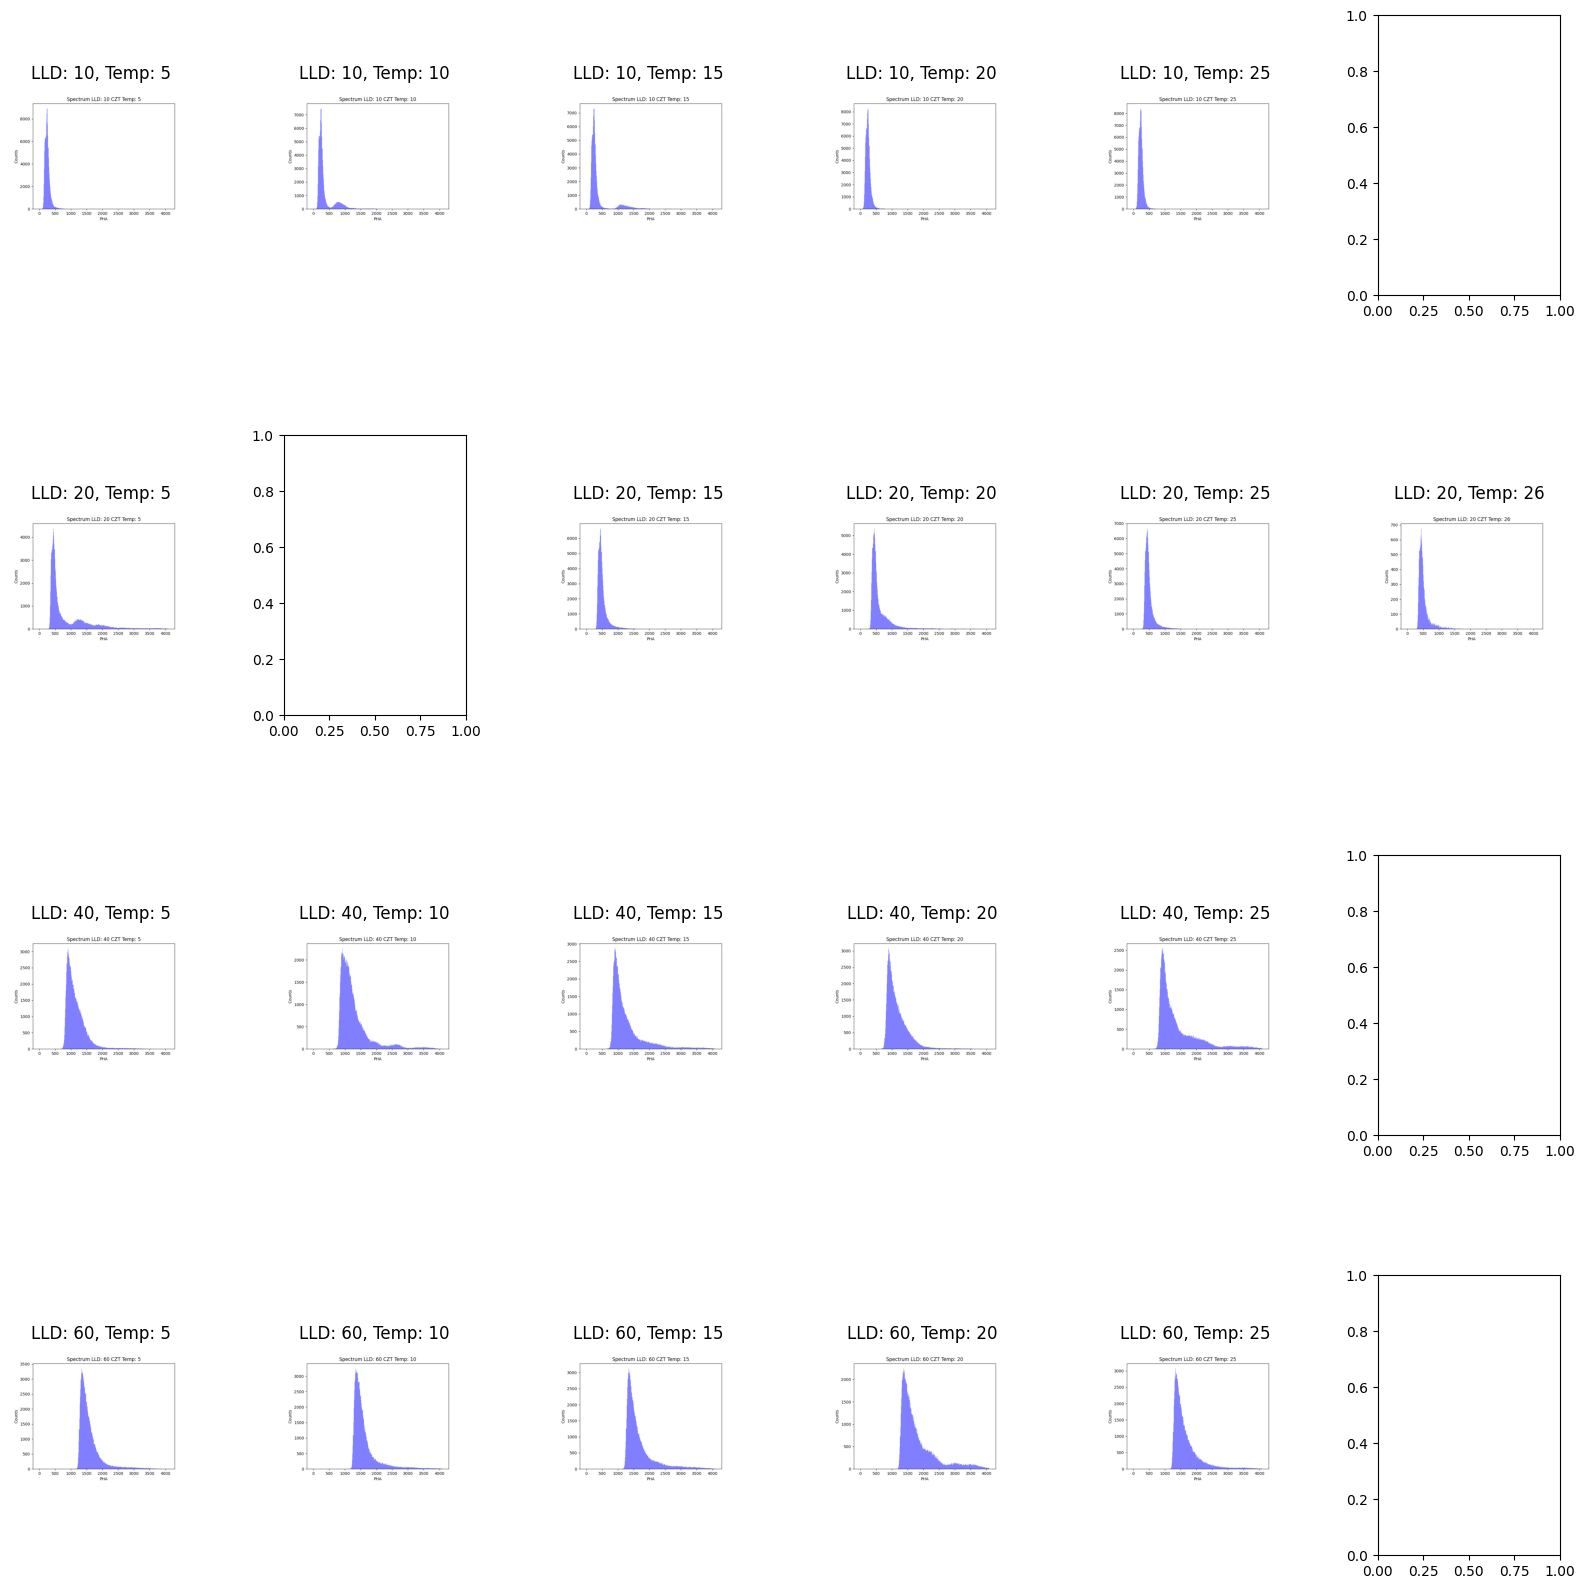

In [10]:
fig

In [11]:
from matplotlib import pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
import numpy as np
import matplotlib.image as mpimg

# Define the number of rows and columns for the subplot
num_rows = 4  # Number of LLD values
num_cols = 6  # Number of temperature values

# Create a figure and axis for the subplot
fig, axs = plt.subplots(num_rows, num_cols, figsize=(20, 20))

# Adjust spacing between subplots
plt.subplots_adjust(wspace=0.5, hspace=0.5)

# Loop through each cell in the subplot
for row in range(num_rows):
    for col in range(num_cols):
        if row == 0:
            lld = 10
        elif row == 1:
            lld = 20
        elif row == 2:
            lld = 40
        else:
            lld = 60

        if col == 0:
            temp = 5
        elif col == 1:
            temp = 10
        elif col == 2:
            temp = 15
        elif col == 3:
            temp = 20
        elif col == 4:
            temp = 25
        else:
            temp = 26

        try:
            # Load heatmap image
            hm_filename = f'hm_{lld}_{temp}.png'
            hm_img = mpimg.imread(hm_filename)

            # Load spectrum image
            sp_filename = f'sp_{lld}_{temp}.png'
            sp_img = mpimg.imread(sp_filename)

            combined_width = hm_img.shape[1] + sp_img.shape[1]
            combined_height = max(hm_img.shape[0], sp_img.shape[0])

# Create a new blank image with the combined width and height
            new_image = np.zeros((combined_height, combined_width, 4))

# Paste the first image into the new image
            new_image[:hm_img.shape[0], :hm_img.shape[1], :] = hm_img

# Paste the second image into the new image
            new_image[:sp_img.shape[0], hm_img.shape[1]:, :] = sp_img            # Plot heatmap in the top half of the cell
            axs[row, col].imshow(new_image, extent=[0, 1, 0.5, 1])
            axs[row, col].axis('off')

            # Plot spectrum in the bottom half of the cell
            

            # Add title to the cell
            axs[row, col].set_title(f'LLD: {lld}, Temp: {temp}')
        except FileNotFoundError:
            print(f"File not found for LLD: {lld}, Temp: {temp}")
            pass

# Save the subplot as a PDF
with PdfPages('subplot_plots.pdf') as pdf:
    pdf.savefig(fig)

plt.close()


File not found for LLD: 10, Temp: 26
File not found for LLD: 20, Temp: 10
File not found for LLD: 40, Temp: 26
File not found for LLD: 60, Temp: 26


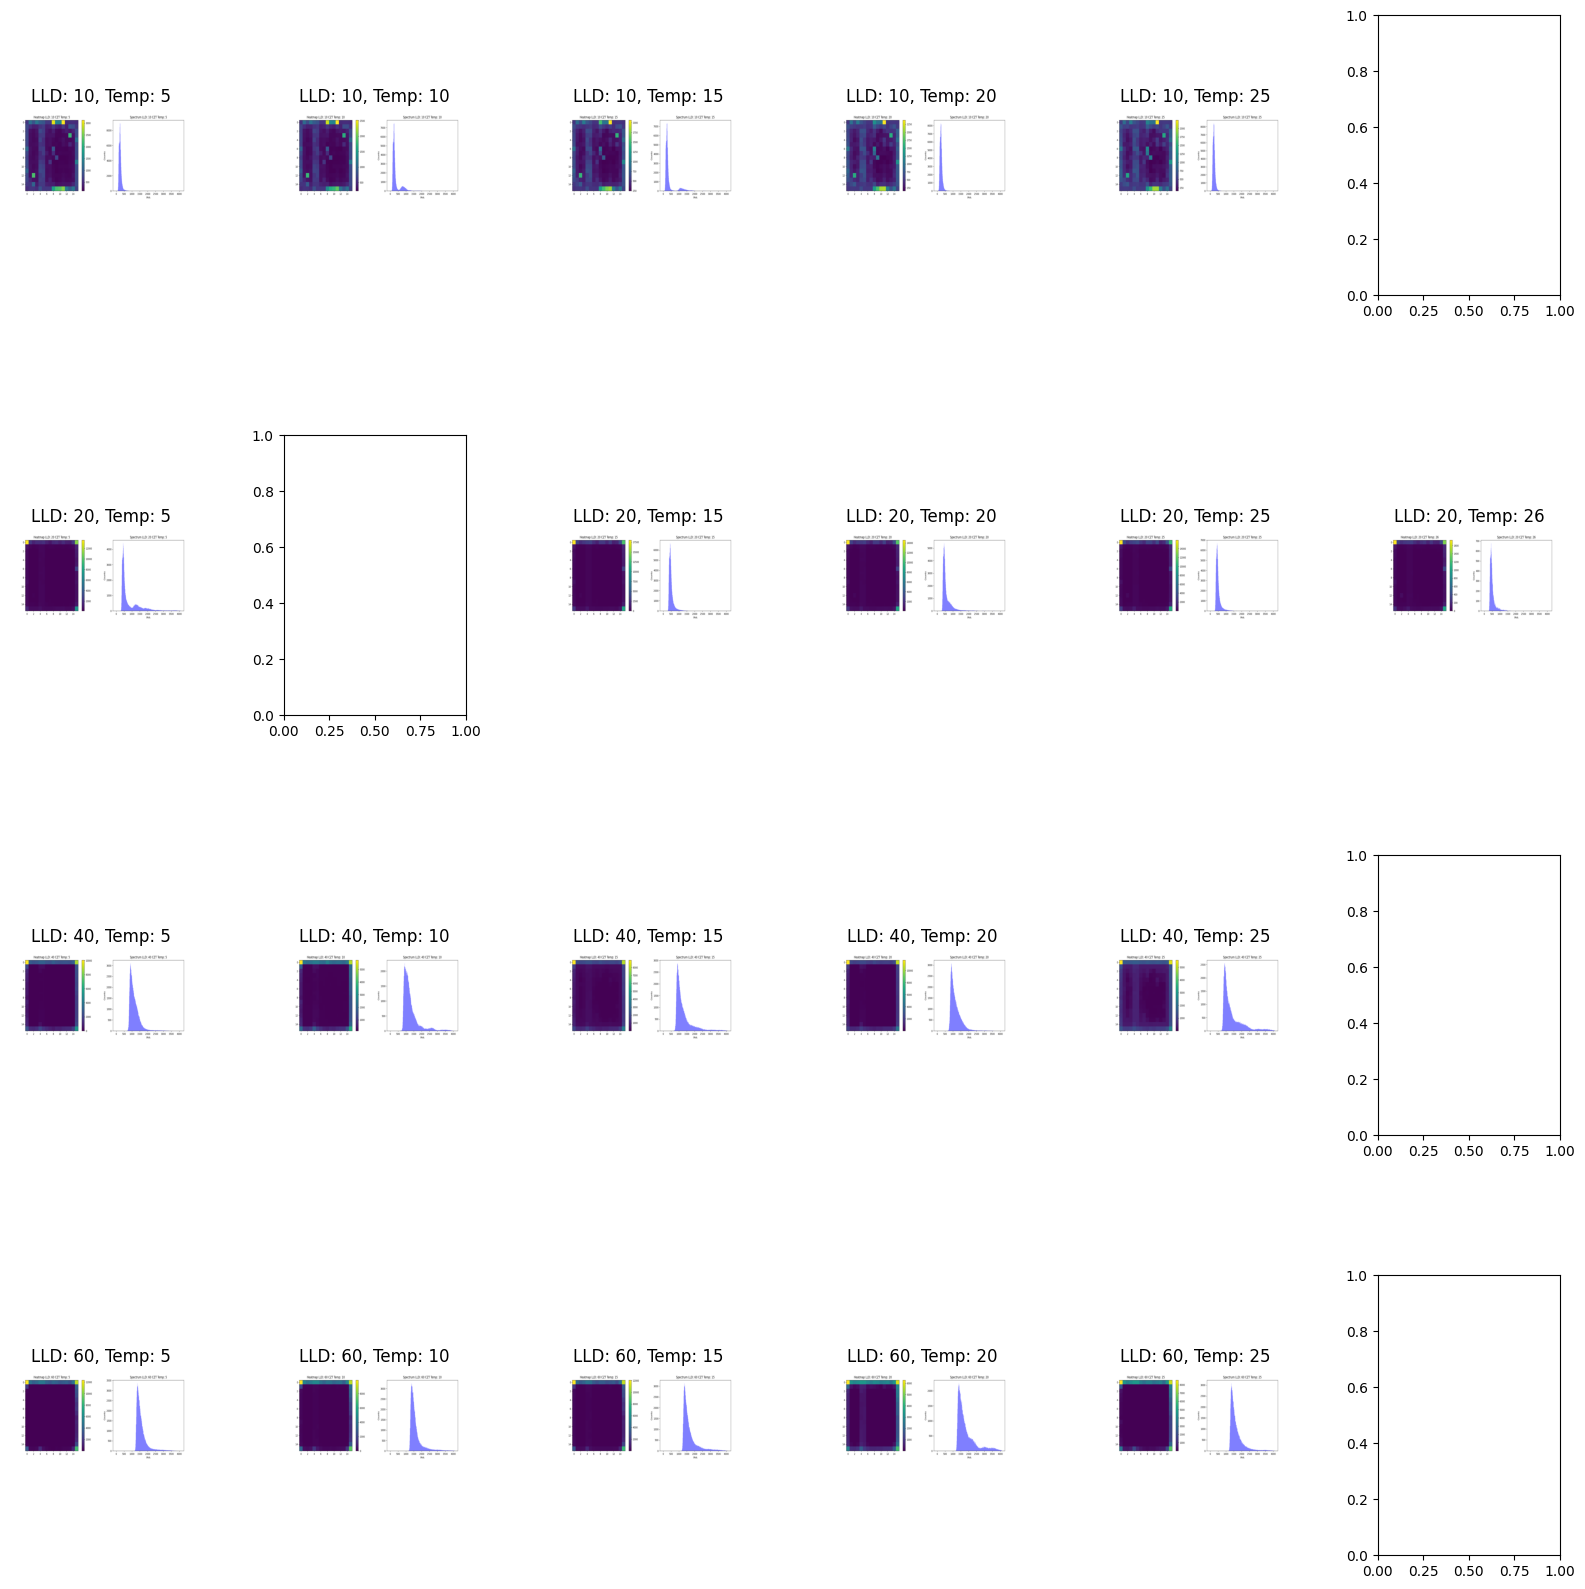

In [12]:
fig

In [13]:
from matplotlib import pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
import numpy as np
import matplotlib.image as mpimg

# Define the number of rows and columns for the subplot
num_rows = 4  # Number of LLD values
num_cols = 6  # Number of temperature values

# Create a figure and axis for the subplot
fig, axs = plt.subplots(num_rows, num_cols, figsize=(25, 25))

# Adjust spacing between subplots
plt.subplots_adjust(wspace=0.1, hspace=0.1)

# Loop through each cell in the subplot
for row in range(num_rows):
    for col in range(num_cols):
        if row == 0:
            lld = 10
        elif row == 1:
            lld = 20
        elif row == 2:
            lld = 40
        else:
            lld = 60

        if col == 0:
            temp = 5
        elif col == 1:
            temp = 10
        elif col == 2:
            temp = 15
        elif col == 3:
            temp = 20
        elif col == 4:
            temp = 25
        else:
            temp = 26

        try:
            # Load heatmap image
            hm_filename = f'hm_{lld}_{temp}.png'
            hm_img = mpimg.imread(hm_filename)

            # Load spectrum image
            sp_filename = f'sp_{lld}_{temp}.png'
            sp_img = mpimg.imread(sp_filename)

            combined_width = hm_img.shape[1] + sp_img.shape[1]
            combined_height = max(hm_img.shape[0], sp_img.shape[0])

            # Create a new blank image with the combined width and height
            new_image = np.zeros((combined_height, combined_width, 4))

            # Paste the first image into the new image
            new_image[:hm_img.shape[0], :hm_img.shape[1], :] = hm_img

            # Paste the second image into the new image
            new_image[:sp_img.shape[0], hm_img.shape[1]:, :] = sp_img

            # Plot the combined image in the cell
            axs[row, col].imshow(new_image, extent=[0, 1, 0, 1])
            axs[row, col].axis('off')
            axs[row, col].set_aspect('auto')  # Ensure aspect ratio is maintained

            # Add title to the cell
            axs[row, col].set_title(f'LLD: {lld}, Temp: {temp}')
        except FileNotFoundError:
            print(f"File not found for LLD: {lld}, Temp: {temp}")
            pass

# Save the subplot as a PDF
with PdfPages('subplot_plots.pdf') as pdf:
    pdf.savefig(fig)

plt.close()


File not found for LLD: 10, Temp: 26
File not found for LLD: 20, Temp: 10
File not found for LLD: 40, Temp: 26
File not found for LLD: 60, Temp: 26


In [ ]:
fig